# Image Classification Model Comparison with PyTorch

### Project Overview:
##### The goal of this project is to build two models that can identify an image and what class it belongs to. We are comparing the performance between ResNet and Vision Transformers (ViT) architectures for image classification.

##### This repository contains a Jupyter Notebook that implements an image classification model using the ResNet18 architecture, as described in the research paper by He, Kaiming, et al. “Deep Residual Learning for Image Recognition.” arXiv, 10 Dec. 2015, arxiv.org/abs/1512.03385. 

<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/1*rrlou8xyh7DeWdtHZk_m4Q.png' width='800'>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
import opendatasets as od

### ResNet18 Model

In [5]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
od.download("https://www.kaggle.com/datasets/saumyamohandas/garbage-classification-image-dataset")

Skipping, found downloaded files in ".\garbage-classification-image-dataset" (use force=True to force download)


In [7]:
train_path = "garbage-classification-image-dataset/dataset/Training"
test_path = "garbage-classification-image-dataset/dataset/Testing"

In [ ]:
# define parameters
num_epochs = 11
batch_size = 10
learning_rate = 0.005

In [ ]:
# Transform to tensors of normalized range [-1, 1]
# Augment the data by performing a random horizontal flip to the data and a random crop

transform_train = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                     transforms.RandomHorizontalFlip(), transforms.Resize([256, 256])])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), transforms.Resize([256, 256])])

In [ ]:
# Import Data
train_dataset = ImageFolder(root=train_path, transform=transform_train)

test_dataset = ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [ ]:
classes = train_dataset.classes
print(classes)

In [ ]:
class ResNet(nn.Module):
    def __init__(self, num_classes=6):
        super(ResNet, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        for param in self.resnet.parameters():
            param.requires_grad = True
        self.resnet.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [ ]:
model = ResNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)


In [ ]:
for name, param in ResNet().named_parameters():
    print(name, param.requires_grad)

In [ ]:
# training loop
for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward propogation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append loss
        train_losses.append(loss.item())

    # Test the model
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Append loss
            test_losses.append(loss.item())

    # Log losses after epoch
    avg_train_loss = np.mean(train_losses)
    avg_test_loss = np.mean(test_losses)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

print('Finished Training')

In [ ]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(6)]
    n_class_samples = [0 for i in range(6)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)


        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
                n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the networks: {acc} %')

    for i in range(6):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(6)]
    n_class_samples = [0 for i in range(6)]
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network: {acc} %')

for i in range(6):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

In [ ]:
examples = iter(test_loader)
images, samples = examples.__next__()

In [ ]:
def imshow(img):
    img = img/2 + 0.2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


In [ ]:
imshow(torchvision.utils.make_grid(images, nrow=5))

In [ ]:
print("Labels for images")
print(samples)
preds = _, predictions = torch.max(model(images.cuda()), 1)

for i in range(10):
    print(f"Predicitons for Image {i+1}")
    print(classes[predictions[i]])


for i in range(10):
    print(f"Truth for Image {i+1}")
    print(classes[samples[i]])

### Vision Transformer Model (ViT)

##### In addition, this notebook contains another image classification model using the Vision Transformer (ViT) architecture, as described in the research paper by Dosovitskiy, Alexey, et al. “An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale.” arXiv, 22 Oct. 2020, https://arxiv.org/abs/2010.11929. Accessed 5 July 2024. 

<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/1*SoXHGxDPUqFQHFbJKYoVLg.png' width='800'>

In [8]:
# define parameters
num_epochs = 11
batch_size = 10
learning_rate = 0.005

In [10]:
# Transform to tensors of normalized range [-1, 1]
# Augment the data by performing a random horizontal flip to the data and a random crop

transform_train = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                     transforms.RandomHorizontalFlip(), transforms.Resize([224, 224])])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), transforms.Resize([224, 224])])

In [11]:
# Import Data
train_dataset = ImageFolder(root=train_path, transform=transform_train)

test_dataset = ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [12]:
classes = train_dataset.classes
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [13]:
class ViT(nn.Module):
    def __init__(self, num_classes=6):
        super(ViT, self).__init__()
        self.ViT = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
        for param in self.ViT.parameters():
            param.requires_grad = True
        self.ViT.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        return self.ViT(x)

In [14]:
model = ViT().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)


In [15]:
for name, param in ViT().named_parameters():
    print(name, param.requires_grad)

ViT.class_token True
ViT.conv_proj.weight True
ViT.conv_proj.bias True
ViT.encoder.pos_embedding True
ViT.encoder.layers.encoder_layer_0.ln_1.weight True
ViT.encoder.layers.encoder_layer_0.ln_1.bias True
ViT.encoder.layers.encoder_layer_0.self_attention.in_proj_weight True
ViT.encoder.layers.encoder_layer_0.self_attention.in_proj_bias True
ViT.encoder.layers.encoder_layer_0.self_attention.out_proj.weight True
ViT.encoder.layers.encoder_layer_0.self_attention.out_proj.bias True
ViT.encoder.layers.encoder_layer_0.ln_2.weight True
ViT.encoder.layers.encoder_layer_0.ln_2.bias True
ViT.encoder.layers.encoder_layer_0.mlp.0.weight True
ViT.encoder.layers.encoder_layer_0.mlp.0.bias True
ViT.encoder.layers.encoder_layer_0.mlp.3.weight True
ViT.encoder.layers.encoder_layer_0.mlp.3.bias True
ViT.encoder.layers.encoder_layer_1.ln_1.weight True
ViT.encoder.layers.encoder_layer_1.ln_1.bias True
ViT.encoder.layers.encoder_layer_1.self_attention.in_proj_weight True
ViT.encoder.layers.encoder_layer_1.s

In [16]:
# training loop
for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward propogation and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append loss
        train_losses.append(loss.item())

    # Test the model
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Append loss
            test_losses.append(loss.item())

    # Log losses after epoch
    avg_train_loss = np.mean(train_losses)
    avg_test_loss = np.mean(test_losses)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

print('Finished Training')

C:\Users\cincy\anaconda3\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/6, Train Loss: 1.3116, Test Loss: 0.8435
Epoch 2/6, Train Loss: 0.6376, Test Loss: 0.6855
Epoch 3/6, Train Loss: 0.4435, Test Loss: 0.5497
Epoch 4/6, Train Loss: 0.2748, Test Loss: 0.5122
Epoch 5/6, Train Loss: 0.1995, Test Loss: 0.4584
Epoch 6/6, Train Loss: 0.0924, Test Loss: 0.3620
Finished Training


In [17]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(6)]
    n_class_samples = [0 for i in range(6)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)


        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
                n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the networks: {acc} %')

    for i in range(6):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(6)]
    n_class_samples = [0 for i in range(6)]
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network: {acc} %')

for i in range(6):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the networks: 88.69565217391305 %
Accuracy of cardboard: 100.0 %
Accuracy of glass: 100.0 %
Accuracy of metal: 100.0 %
Accuracy of paper: 100.0 %
Accuracy of plastic: 100.0 %
Accuracy of trash: 100.0 %
Accuracy of the network: 97.92 %
Accuracy of cardboard: 99.70149253731343 %
Accuracy of glass: 95.96330275229357 %
Accuracy of metal: 99.18032786885246 %
Accuracy of paper: 99.1919191919192 %
Accuracy of plastic: 95.65217391304348 %
Accuracy of trash: 99.33110367892976 %


In [28]:
examples = iter(test_loader)
images, samples = examples.__next__()

NameError: name 'test_loader' is not defined

In [19]:
def imshow(img):
    img = img/2 + 0.2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


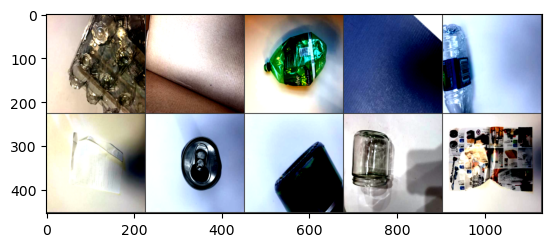

In [20]:
imshow(torchvision.utils.make_grid(images, nrow=5))

In [18]:
print("Labels for images")
print(samples)
preds = _, predictions = torch.max(model(images.cuda()), 1)

for i in range(10):
    print(f"Predicitons for Image {i+1}")
    print(classes[predictions[i]])


for i in range(10):
    print(f"Truth for Image {i+1}")
    print(classes[samples[i]])

Labels for images


NameError: name 'samples' is not defined

### Conclusion:
##### In conclusion, I recommend using ResNet models when training a machine to classify images. I think this because while it is known that ResNet models train faster and Vision Transformer models are known for their strong performance in certain scenarios, it does not offer a significant improvement in accuracy in this instance. Therefore, the quicker training time of ResNet makes it the more efficient choice without sacrificing substantial model performance.